#  Working with LIGO Data
(This notebook was adapted from [Tutorial 1.2](https://github.com/gw-odw/odw-2020/blob/master/Day_1/Tuto%201.2%20Open%20Data%20access%20with%20GWpy.ipynb) from the Open Data Workshop \#3)

In the previous notebook, we talked about the properties of waves, and how you can convert between the time and frequency representation for discretely-sampled data. Now, we will see how this applies to real LIGO data. We will use a few pre-packaged python modules specifically for processing and accessing gravitational-wave data. First, we need to install these packages:

In [1]:
# -- Uncomment following line if running in Google Colab
#! pip install -q 'gwpy==1.0.1'

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [2]:
%pylab inline
import gwpy
print(gwpy.__version__)

Populating the interactive namespace from numpy and matplotlib
1.0.1


## A note on object-oriented programming

Before we dive too deeply, its worth a quick aside on object-oriented programming (OOP).
GWpy is heavily object-oriented, meaning almost all of the code you run using GWpy is based around an object of some type, e.g. `TimeSeries`.
Most of the methods (functions) we will use are attached to an object, rather than standing alone, meaning you should have a pretty good idea of what sort of data you are dealing with (without having to read the documentation!).

For a quick overview of object-oriented programming in Python, see [this blog post by Jeff Knupp](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/).

## Handling data in the time domain
#### Finding open data
When the LIGO-Virgo Collaborations publish the detection of a new event, they usually also release the data surrounding the time of the detection. This data are stored on the Gravitational-Wave Open Science Center, or [GWOSC.](https://www.gw-openscience.org/about/) The `gwosc` module can be used to query for what data are available on GWOSC. Let's try to download the data for GW150914, the first direct detection of an astrophysical gravitational-wave signal from a BBH (binary black hole system).

We can use the [`TimeSeries.fetch_open_data`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fetch_open_data) method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times.
We can query for the GPS time of an event as follows:

In [3]:
from gwosc.datasets import event_gps
gps = event_gps('GW150914')
print(gps)

1126259462.4


Now we can build a `[start, end)` GPS segment to include 10 seconds around this time, using integers for convenience:

In [4]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1126259457, 1126259467)


and can now query for the full data.
For this example we choose to retrieve data for the LIGO-Livingston interferometer, using the identifier `'L1'`.
We could have chosen any of

- `'G1`' - GEO600
- `'H1'` - LIGO-Hanford
- `'L1'` - LIGO-Livingston
- `'V1'` - (Advanced) Virgo

In the future, the Japanese observatory KAGRA will come online, with the identifier `'K1'`.

In [5]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(hdata)

Fetched 1 URLs from www.gw-openscience.org for [1126259457 .. 1126259467))
Reading data... [Done]
TimeSeries([-9.31087178e-19, -9.75697062e-19, -1.01074940e-18,
            ..., -1.13460681e-18, -1.11414494e-18,
            -1.15931435e-18]
           unit: dimensionless,
           t0: 1126259457.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


##### The `verbose=True` flag lets us see that GWpy has discovered two files that provides the data for the given interval, downloaded them, and loaded the data.
The files are not stored permanently, so next time you do the same call, it will be downloaded again, however, if you know you might repeat the same call many times, you can use `cache=True` to store the file on your computer or in the cloud on Google collab.

We have now downloaded real LIGO data for GW150914! These are the actual data used in the analysis that discovered the first binary black hole merger. To sanity check things, we can easily make a plot, using the [`plot()`](https://gwpy.github.io/docs/stable/timeseries/plot.html) method of the `data` `TimeSeries`.

Text(0, 0.5, 'h(t)')

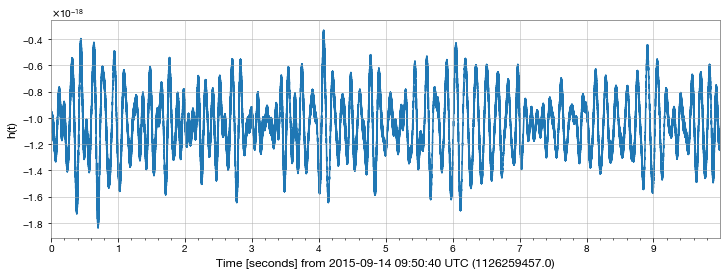

In [6]:
plot = hdata.plot()
plt.ylabel('h(t)')

The `hdata` object has several methods that we can use to learn more about this data. [Here](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#timeseries) is full list of all the attributes and methods of this object type. Let's print the $\Delta t$, sampling rate, duration, and associated array of times:

In [7]:
print('Duration: {}'.format(hdata.duration))
print('dt: {}'.format(hdata.dt))
print('Sampling rate: {}'.format(hdata.sample_rate))
# confirm that sampling_rate = 1/dt
print('Sampling rate: {}'.format(1./hdata.dt))
hdata.times

Duration: 10.0 s
dt: 0.000244140625 s
Sampling rate: 4096.0 Hz
Sampling rate: 4096.0 1 / s


<Index [1.12625946e+09, 1.12625946e+09, 1.12625946e+09, ...,
        1.12625947e+09, 1.12625947e+09, 1.12625947e+09] s>

## Handling data in the frequency domain using the Fourier transform

As we saw in the last notebook, the [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) is a widely-used mathematical tool to expose the frequency-domain content of a time-domain signal, meaning we can see which frequencies contian lots of power, and which have less.

We can calculate the Fourier transform of our `TimeSeries` using the [`fft()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft) method:

In [8]:
fft = hdata.fft()
print(fft)

FrequencySeries([-1.05219333e-18+0.00000000e+00j,
                 -9.36314427e-22+6.61514979e-23j,
                 -8.74693847e-22-3.26717194e-23j, ...,
                  6.63325463e-24-1.10870240e-26j,
                  6.73663868e-24-7.82178218e-26j,
                  6.69598891e-24+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1126259457.0,
                name: Strain,
                channel: None)


The result is a [`FrequencySeries`](https://gwpy.github.io/docs/stable/frequencyseries/), with complex amplitude, representing the amplitude and phase of each frequency in our data. The data $h(f)$ has both a real and a complex component:
$$h(f) = h_\mathrm{Re}(f) + ih_{\mathrm{Im}}(f)$$
We can't plot both of these components at the same time on a 2D plot, and we are generally interested in the overall amplitude:
$$h_\mathrm{Amp}(f) = \sqrt{h_\mathrm{Re}^{2}(f) + h_{\mathrm{Im}}^{2}(f)}$$
We can use `abs()` to extract the amplitude and plot that:

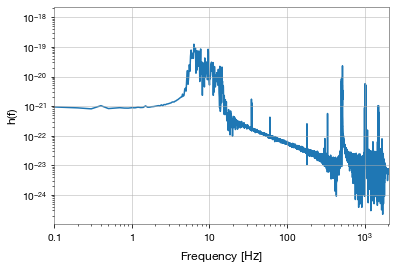

In [9]:
plot = fft.abs().plot(xscale="log", yscale="log")
plt.ylabel('h(f)')
plot.show(warn=False)

We are missing one key step to get back a sensible-looking Fourier transform. When we did this on sine and cosine functions in the previous notebook, our data was periodic, meaning that if you wrapped the end around to the beginning, there would be no discontinuities. However, this is not true for real gravitational-wave data. The 10-second chunk of data we've loaded here does not repeat indefinitely. The next 10-second chunk of data would look completely different. We need to apply a window function to our time-domain data before transforming, which deals with the discontinuities by tapering the data at the start and end of the segment. Different window functions have different tapering shapes. Here we'll use the [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html) module to apply a Hann windown, but you can check out other window shapes [here.](https://en.wikipedia.org/wiki/Window_function#Hann_and_Hamming_windows) What happens when you change `'hann'` to `('tukey', 0.5)` instead?

/Users/sylviabiscoveanu/anaconda3/envs/igwn-py37/lib/python3.7/site-packages/gwpy/plot/plot.py:281: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super(Plot, self).show(warn=warn)


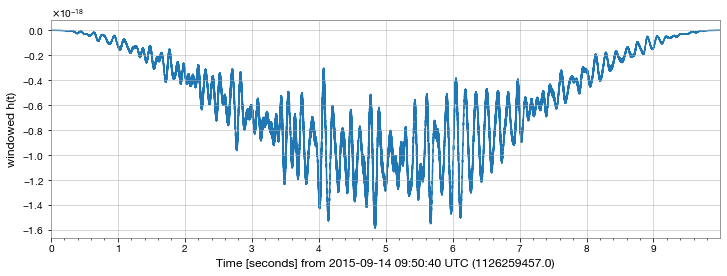

In [10]:
from scipy.signal import get_window
window = get_window('hann', hdata.size)
hwin = hdata * window
plot = hwin.plot()
plt.ylabel('windowed h(t)')
plot.show()

The data look completely different! Let's try our transform again and see what we get

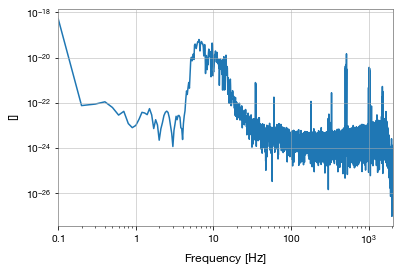

In [11]:
fftamp = hwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

What is happening at low frequencies? Gravitational-wave detectors have very limited sensitivity at low frequencies due to **seismic noise**, which basically just means ground motion. The natural shaking of the earth at these frequencies interferes with our ability to detect gravitational-waves there, so the data below about 10 Hz are usually discarded as unreliable.

## Properties of LIGO data - Gaussianity

We typically assume that LIGO data are **Gaussian**. Let's take a look at what this means. A Gaussian, also known as a "bell curve" or "normal distribution" is a probability distribution for a random variable $x$ characterized by a mean $\mu$ and width $\sigma$:
$$p(x) = \frac{1}{\sqrt{2\pi\sigma^{2}}}\exp{\bigg(-\frac{(x-\mu)^{2}}{2\sigma^{2}}\bigg)}$$
Let's plot some of these distributions. First we define a function called `gaussian` to compute $p(x)$ for some values of $x$, $\mu$, and $\sigma$:

In [12]:
def gaussian(x, mu, sigma):
    return 1./np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-mu)**2/(2*sigma**2))

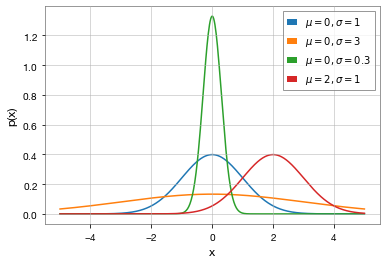

In [13]:
x = np.linspace(-5, 5, 500)
px1 = gaussian(x, 0, 1)
px2 = gaussian(x, 0, 3)
px3 = gaussian(x, 0, 0.3)
px4 = gaussian(x, 2, 1)
plt.plot(x, px1, label=r'$\mu=0, \sigma=1$')
plt.plot(x, px2, label=r'$\mu=0, \sigma=3$')
plt.plot(x, px3, label=r'$\mu=0, \sigma=0.3$')
plt.plot(x, px4, label=r'$\mu=2, \sigma=1$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend()

What does this distribution actually tell us about the variable $x$? Let's look at an example, where $x$ represents the test scores for a class of 100 students. We generate 100 random test scores as follows:

In [15]:
x = np.random.randn(1000)*7+75

Calculate the mean and standard deviation of $x$, and store the mean in a variable called `mu` and the standard deviation in a variable called `sigma`. How do those values compare to the values multiplying and being added to the `randn` function? What happens if you instead generate 10,000 samples for $x$? Now let's plot a histogram of $x$, where the possible range of values of $x$ is split into bins, and the histogram shows how many of the samples from $x$ are in each bin, and add a plot of our gaussian with mean and sigma given by the values we calculated above to compare:

Text(0.5, 0, 'x')

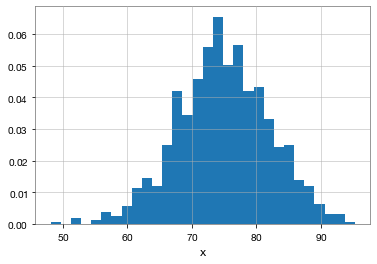

In [16]:
hist, bins, _ = plt.hist(x, bins=30, density=True)
plt.xlabel('x')

The Gaussian curve matches the samples from $x$ very well. This shouldn't be surprising since we know we drew them from a Gaussian distribtuion. It turns out that LIGO data also follow a Gaussian distribution, but what are the mean and sigma for this distribution? The mean is 0, and the width is a frequency-dependent quantity called the **power spectral density**, or **PSD**. When we plotted the amplitude of the FFT of our 10-second data segment above, this was the **amplitude spectral density**, or **ASD**. The PSD is just the $\mathrm{ASD^{2}}$. What does the PSD actually represent, and how is it determined?

## The Amplitude Spectral Density
![PSD](https://dcc.ligo.org/public/0149/T1800044/005/aLIGO_newDesign.pdf)

We can use a known PSD to generate some fake Gaussian LIGO data. Let's download the predicted PSD for advanced LIGO when it reaches design sensitivity:

In [17]:
!wget https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt

--2020-07-13 19:16:11--  https://dcc.ligo.org/public/0149/T1800044/005/aLIGODesign.txt
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56290 (55K) [text/plain]
Saving to: 'aLIGODesign.txt.1'

aLIGODesign.txt.1   100%[===================>]  54.97K   360KB/s    in 0.2s    

2020-07-13 19:16:12 (360 KB/s) - 'aLIGODesign.txt.1' saved [56290/56290]



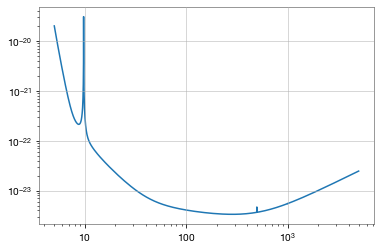

In [18]:
freqs, asd = np.loadtxt('aLIGODesign.txt', unpack=True)
plt.loglog(freqs, asd)

This is what the ASD we just downloaded looks like. Now let's generate some Gaussian data which is "colored" by this ASD. Remember that $h(f)$ has both real and imaginary components, so we need to generate two sets of Gaussian data independently.

Text(0, 0.5, 'ASD [$1/\\sqrt{\\mathrm{Hz}}$]')

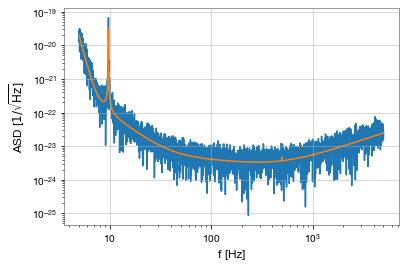

In [19]:
hf = asd*(np.random.randn(len(asd)) + 1j*np.random.randn(len(asd)))
plt.loglog(freqs, abs(hf))
plt.loglog(freqs, asd)
plt.xlabel('f [Hz]')
plt.ylabel(r'ASD [$1/\sqrt{\mathrm{Hz}}$]')

The ASD we used to "color" the data in orange lies right in the middle of the data, and the simulated data looks a lot like the real data we used to compute the ASD in the previous section! Now let's look at one final test of Gaussianity. Let's make a histogram of the data and fit it with a Gaussian like we did for our test set $x$ above. We will first **whiten** the data by dividing it by the ASD to make the plot more manageable:

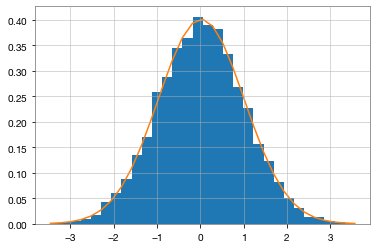

In [20]:
whitened_data_real = np.real(hf/asd)
mu = np.mean(whitened_data_real)
sigma = np.std(whitened_data_real)
hist, bins, _ = plt.hist(whitened_data_real, bins=30, density=True)
plt.plot(bins, gaussian(bins, mu, sigma))

As expected, the histogram and a Gaussian distribution match up! Now let's go on to see how the ASD/PSD is estimated using real data.

## Calculating the power spectral density

In practice, we typically use a large number of FFTs to estimate an average power spectral density over a long period of data. A longer stretch of data is divided into individual segments, the PSD is calculated for each segment, and the final estimated PSD is the average of those from individual segments. The more segments you average, the better the resolution of your PSD will be.
We can do this using the [`asd()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) method, which uses [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to combine FFTs of overlapping, windowed chunks of data.

(2e-24, 1e-20)

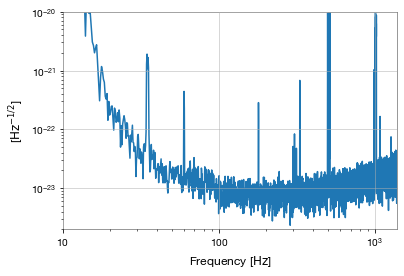

In [26]:
asd = hdata.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show(warn=False)
plt.xlim(10, 1400)
plt.ylim(2e-24, 1e-20)

What happens if you make the `fftlength` variable above longer or shorter? This sets the length of the individual segments that are being averaged over.
For the LIGO-Hanford data we loaded, we can see large spikes at certain frequencies, including

- ~300 Hz
- ~500 Hz
- ~1000 Hz

The [O2 spectral lines](https://www.gw-openscience.org/o2speclines/) page on GWOSC describes a number of these spectral features for O2, with some of them being forced upon us, and some being deliberately introduced to help with interferometer control.

Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

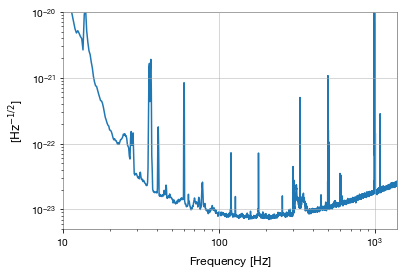

In [27]:
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")
plot = hasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(5e-24, 1e-20)
plot.show(warn=False)

Now we can see some more features, including sets of lines around ~30 Hz and ~65 Hz, and some more isolated lines through the more sensitive region.

For comparison, we can load the LIGO-Livingston data and plot that as well:

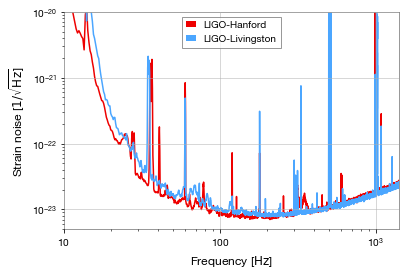

In [28]:
# get Livingston data
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(lasd2, label='LIGO-Livingston', color='gwpy:ligo-livingston')

# update the Hanford line to use standard colour, and have a label
hline = ax.lines[0]
hline.set_color('gwpy:ligo-hanford')  # change colour of Hanford data
hline.set_label('LIGO-Hanford')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

Now we can see clearly the relative sensitivity of each LIGO instrument, the common features between both, and those unique to each observatory. Which instrument is more sensitive at low frequencies, below 100 Hz?

### Challenge Question 1:

The peak amplitude in the LIGO-Livingston time-series data occurs at approximately 5 seconds into the plot above and is undetectable above the background noise by the eye. Plot the data for the LIGO-Hanford detector around GW150914 using the same 10-second segment. Looking at your new LIGO-Handford plot, can your eye identify a signal peak? 

### Challenge Question 2 :

Make an ASD around the time of an O3 event, GW190412 for L1 detector .  Compare this with the ASDs around GW150914 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?
